# Correlating well log pairs: Complex Dynamic Time Warping with boundary constraints

## Introduction to dynamic time warping

In [ ]:
# Data manipulation and analysis
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import glob
from IPython.display import Image as IPImage, display
from scipy import stats
from matplotlib.lines import Line2D
from itertools import combinations
warnings.filterwarnings('ignore')

from pyCoreRelator import (
    run_comprehensive_dtw_analysis,
    find_complete_core_paths,
    calculate_interpolated_ages,
    load_log_data,
    plot_core_data,
    plot_correlation_distribution,
    load_core_age_constraints
)

<hr>

### Test with Cascadia hi-res MS logs

### Define core pairs

In [ ]:
# Define core names as variables for easy reference
# CORE_A = "M9907-22PC"
CORE_A = "M9907-23PC"
# CORE_A = "M9907-11PC"
# CORE_A = "RR0207-56PC" 

# CORE_B = "M9907-25PC"
CORE_B = "M9907-11PC"
# CORE_B = "RR0207-56PC" 

#### Data structures and core images

In [ ]:
# Define log columns to extract
# LOG_COLUMNS = ['hiresMS', 'CT', 'R', 'G', 'B']  # Choose which logs to include
# LOG_COLUMNS = ['hiresMS', 'CT', 'Lumin']  # Choose which logs to include
LOG_COLUMNS = ['hiresMS']  # Choose which logs to include
DEPTH_COLUMN = 'SB_DEPTH_cm'

# Define directory paths
mother_dir = '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/'

# Define paths for Core A
core_a_log_paths = {
    'hiresMS': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_hiresMS_MLfilled.csv',
    'CT': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_CT_MLfilled.csv',
    'Lumin': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
    'R': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
    'G': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
    'B': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
    'Den_gm/cc': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_MST_MLfilled.csv'
}

core_a_rgb_img_path = f"{mother_dir}_compiled_logs/{CORE_A}/{CORE_A}_RGB.tiff"
core_a_ct_img_path = f"{mother_dir}_compiled_logs/{CORE_A}/{CORE_A}_CT.tiff"

# Define paths for Core B
core_b_log_paths = {
    'hiresMS': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_hiresMS_MLfilled.csv',
    'CT': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_CT_MLfilled.csv',
    'Lumin': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
    'R': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
    'G': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
    'B': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
    'Den_gm/cc': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_MST_MLfilled.csv'
}
core_b_rgb_img_path = f"{mother_dir}_compiled_logs/{CORE_B}/{CORE_B}_RGB.tiff"
core_b_ct_img_path = f"{mother_dir}_compiled_logs/{CORE_B}/{CORE_B}_CT.tiff"

# Define column mapping for alternative column names
column_alternatives = {
    'hiresMS': ['MS'],
    'CT': ['CT_value'],
    'R': ['R', 'red', 'Red'],
    'G': ['G', 'green', 'Green'],
    'B': ['B', 'blue', 'Blue'],
    'Lumin': ['luminance', 'Luminance'],
    'Den_gm/cc': ['Density', 'density']
}

# Load data for Core A
log_a, md_a, available_columns_a, rgb_img_a, ct_img_a = load_log_data(
    core_a_log_paths,
    {'rgb': core_a_rgb_img_path, 'ct': core_a_ct_img_path},
    LOG_COLUMNS,
    depth_column=DEPTH_COLUMN,
    normalize=True,
    column_alternatives=column_alternatives
)

print("\n=== DEBUG: Core A Loading ===")
print(f"LOG_COLUMNS requested: {LOG_COLUMNS}")
print(f"Available columns loaded: {available_columns_a}")
print(f"Shape of log_a: {log_a.shape}")
print(f"Type of log_a: {type(log_a)}")
if hasattr(log_a, 'ndim'):
    print(f"log_a dimensions: {log_a.ndim}")
    if log_a.ndim > 1:
        print(f"log_a has {log_a.shape[1]} columns\n")
    else:
        print("log_a is 1D (single column)\n")

# Load data for Core B
log_b, md_b, available_columns_b, rgb_img_b, ct_img_b = load_log_data(
    core_b_log_paths,
    {'rgb': core_b_rgb_img_path, 'ct': core_b_ct_img_path},
    LOG_COLUMNS,
    depth_column=DEPTH_COLUMN,
    normalize=True,
    column_alternatives=column_alternatives
)

print("\n=== DEBUG: Core B Loading ===")
print(f"LOG_COLUMNS requested: {LOG_COLUMNS}")
print(f"Available columns loaded: {available_columns_b}")
print(f"Shape of log_b: {log_b.shape}")
print(f"Type of log_b: {type(log_b)}")
if hasattr(log_b, 'ndim'):
    print(f"log_b dimensions: {log_b.ndim}")
    if log_b.ndim > 1:
        print(f"log_b has {log_b.shape[1]} columns\n")
    else:
        print("log_b is 1D (single column)\n")

In [ ]:
%matplotlib inline

# Define paths to the CSV files
pickeddepth_a_csv = f'pickeddepth/{CORE_A}_pickeddepth.csv'
pickeddepth_b_csv = f'pickeddepth/{CORE_B}_pickeddepth.csv'

# Load picked depths and categories from CSV files
if os.path.exists(pickeddepth_b_csv):
    picked_data_b = pd.read_csv(pickeddepth_b_csv)
    # Combine depths and categories into tuples
    picked_b = list(zip(picked_data_b['picked_depths_cm'].values.tolist(), 
                        picked_data_b['category'].values.tolist()))
    print(f"Loaded {len(picked_b)} picked depths for {CORE_B}")
else:
    print(f"Warning: {pickeddepth_b_csv} not found. Using empty list for picked_b.")
    picked_b = []

if os.path.exists(pickeddepth_a_csv):
    picked_data_a = pd.read_csv(pickeddepth_a_csv)
    # Combine depths and categories into tuples
    picked_a = list(zip(picked_data_a['picked_depths_cm'].values.tolist(), 
                        picked_data_a['category'].values.tolist()))
    print(f"Loaded {len(picked_a)} picked depths for {CORE_A}")
else:
    print(f"Warning: {pickeddepth_a_csv} not found. Using empty list for picked_a.")
    picked_a = []

# Create uncertainty arrays (assuming uncertainty size is 2 cm)
picked_uncertainty_b = [1] * len(picked_b)
picked_uncertainty_a = [1] * len(picked_a)

In [ ]:
# Extract depths and categories from the loaded tuples
picked_depths_a = [depth for depth, category in picked_a] if picked_a else []
picked_categories_a = [category for depth, category in picked_a] if picked_a else []

picked_depths_b = [depth for depth, category in picked_b] if picked_b else []
picked_categories_b = [category for depth, category in picked_b] if picked_b else []

# Now plot the cores with enhanced plot_core_data function
is_multilog = log_a.ndim > 1 and log_a.shape[1] > 1
fig_a, ax_a = plot_core_data(
    # Input data
    md_a,                                           # depth array
    log_a,                                          # log data array
    f"{CORE_A}",                                    # core name
    # Image data
    rgb_img=rgb_img_a,                              # RGB image array
    ct_img=ct_img_a,                                # CT scan image array
    # Data configuration
    available_columns=available_columns_a,          # available data columns
    is_multilog=is_multilog,                        # multi-column log flag
    # Picked depth data
    picked_depths=picked_depths_a,                  # picked depth values
    picked_categories=picked_categories_a,          # picked categories
    picked_uncertainties=picked_uncertainty_a,      # uncertainty values
    # Visualization settings
    figsize=(20, 4),                                # figure size (width, height)
    show_category=[1],                              # categories to display
    show_bed_number=True                            # show bed numbers flag
)

# Do the same for Core B
is_multilog = log_b.ndim > 1 and log_b.shape[1] > 1
fig_b, ax_b = plot_core_data(
    # Input data
    md_b,                                           # depth array
    log_b,                                          # log data array
    f"{CORE_B}",                                    # core name
    # Image data
    rgb_img=rgb_img_b,                              # RGB image array
    ct_img=ct_img_b,                                # CT scan image array
    # Data configuration
    available_columns=available_columns_b,          # available data columns
    is_multilog=is_multilog,                        # multi-column log flag
    # Picked depth data
    picked_depths=picked_depths_b,                  # picked depth values
    picked_categories=picked_categories_b,          # picked categories
    picked_uncertainties=picked_uncertainty_b,      # uncertainty values
    # Visualization settings
    figsize=(20, 4),                                # figure size (width, height)
    show_category=[1],                              # categories to display
    show_bed_number=True                            # show bed numbers flag
)

plt.tight_layout()
plt.show()

<hr>

# Usage Examples and Executions

In [ ]:
# Extract a subset of picked depths of category 1 for both cores
all_depths_a_cat1 = np.array([depth for depth, category in picked_a if category == 1]).astype('float32')
all_depths_b_cat1 = np.array([depth for depth, category in picked_b if category == 1]).astype('float32')

#### extract ages

In [ ]:
# Load age constraints for both cores
consider_adjacent_core = True

data_columns = {
    'age': 'calib502_agebp',
    'pos_error': 'calib502_2sigma_pos', 
    'neg_error': 'calib502_2sigma_neg',
    'min_depth': 'mindepth_cm',
    'max_depth': 'maxdepth_cm',
    'in_sequence': 'in_sequence',
    'core': 'core',
    'interpreted_bed': 'interpreted_bed'
}

# Configuration
age_base_path = '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/Age constraints/Goldfinger2012'

# Load age constraints for both cores
age_data_a = load_core_age_constraints(CORE_A, age_base_path, consider_adjacent_core, data_columns)
age_data_b = load_core_age_constraints(CORE_B, age_base_path, consider_adjacent_core, data_columns)

uncertainty_method='MonteCarlo'   # 'MonteCarlo', 'Linear', or 'Gaussian'

In [ ]:
# Calculate interpolated ages for Core A using the function
pickeddepth_ages_a = calculate_interpolated_ages(
    # Input data
    picked_depths=all_depths_a_cat1,                                     # depths to interpolate ages for
    age_constraints_depths=age_data_a['depths'],                         # age constraint depths
    age_constraints_ages=age_data_a['ages'],                             # age constraint ages
    age_constraints_pos_errors=age_data_a['pos_errors'],                 # positive errors
    age_constraints_neg_errors=age_data_a['neg_errors'],                 # negative errors
    age_constraints_in_sequence_flags=age_data_a['in_sequence_flags'],   # in-sequence flags
    age_constraint_source_core=age_data_a['core'],                       # source core for each constraint
    # Core boundaries
    top_bottom=True,                                                     # include top and bottom depths/ages
    top_depth=0.0,                                                       # top of core depth
    bottom_depth=md_a[-1],                                               # max depth of core a
    top_age=0,                                                           # default age at top of core
    top_age_pos_error=75,                                                # default positive uncertainty of top age
    top_age_neg_error=75,                                                # default negative uncertainty of top age
    # Uncertainty calculation
    uncertainty_method=uncertainty_method,                               # uncertainty calculation method: 'MonteCarlo', 'Linear', or 'Gaussian'
    n_monte_carlo=10000,                                                 # number of Monte Carlo iterations
    # Visualization and output
    show_plot=True,                                                      # display plot
    core_name=CORE_A,                                                    # core name for plot title
    export_csv=False,                                                    # export results to CSV
    mute_mode=True
)

# # Print the interpolated ages
# print(f"\nEstimated Ages for picked depths in {CORE_A}:")
# for i, depth in enumerate(pickeddepth_ages_a['depths']):
#     print(f"Depth: {depth:.2f} cm, Age: {pickeddepth_ages_a['ages'][i]:.1f} years BP (+{pickeddepth_ages_a['pos_uncertainties'][i]:.1f} ; -{pickeddepth_ages_a['neg_uncertainties'][i]:.1f})")

# Calculate interpolated ages for Core B using the function
pickeddepth_ages_b = calculate_interpolated_ages(
    # Input data
    picked_depths=all_depths_b_cat1,                                     # depths to interpolate ages for
    age_constraints_depths=age_data_b['depths'],                         # age constraint depths
    age_constraints_ages=age_data_b['ages'],                             # age constraint ages
    age_constraints_pos_errors=age_data_b['pos_errors'],                 # positive errors
    age_constraints_neg_errors=age_data_b['neg_errors'],                 # negative errors
    age_constraints_in_sequence_flags=age_data_b['in_sequence_flags'],   # in-sequence flags
    age_constraint_source_core=age_data_b['core'],                       # source core for each constraint
    # Core boundaries
    top_bottom=True,                                                     # include top and bottom depths/ages
    top_depth=0.0,                                                       # top of core depth
    bottom_depth=md_b[-1],                                               # max depth of core b
    top_age=0,                                                           # default age at top of core
    top_age_pos_error=75,                                                # default positive uncertainty of top age
    top_age_neg_error=75,                                                # default negative uncertainty of top age
    # Uncertainty calculation
    uncertainty_method=uncertainty_method,                               # uncertainty calculation method: 'MonteCarlo', 'Linear', or 'Gaussian'
    n_monte_carlo=10000,                                                 # number of Monte Carlo sampling iterations
    # Visualization and output
    show_plot=True,                                                      # display plot
    core_name=CORE_B,                                                    # core name for plot title
    export_csv=False,                                                    # export results to CSV
    mute_mode=True
)

# print(f"\nEstimated Ages for picked depths in {CORE_B}:")
# for i, depth in enumerate(pickeddepth_ages_b['depths']):
#     print(f"Depth: {depth:.2f} cm, Age: {pickeddepth_ages_b['ages'][i]:.1f} years BP (+{pickeddepth_ages_b['pos_uncertainties'][i]:.1f} ; -{pickeddepth_ages_b['neg_uncertainties'][i]:.1f})")

In [ ]:
# # Load estimated boundary age data for both cores from CSV files
# cores = [CORE_A, CORE_B]
# pickeddepth_ages = {}

# for core in cores:
#     core_age_csv = f"outputs/{core}_pickeddepth_age_{uncertainty_method}.csv"
#     if os.path.exists(core_age_csv):
#         df_ages = pd.read_csv(core_age_csv)
#         pickeddepth_ages[core] = {
#             'depths': df_ages['picked_depths_cm'].values.astype('float32').tolist(),
#             'ages': df_ages['est_age'].values.astype('float32').tolist(),
#             'pos_uncertainties': df_ages['est_age_poserr'].values.astype('float32').tolist(),
#             'neg_uncertainties': df_ages['est_age_negerr'].values.astype('float32').tolist()
#         }
#         print(f"Loaded estimated boundary age data for {core} from CSV file")
#     else:
#         print(f"Warning: Could not find boundary age data CSV for {core}")

# # Assign to individual variables for backward compatibility
# if CORE_A in pickeddepth_ages:
#     pickeddepth_ages_a = pickeddepth_ages[CORE_A]
# if CORE_B in pickeddepth_ages:
#     pickeddepth_ages_b = pickeddepth_ages[CORE_B]


<hr>

## Compute r-value distribution for all stituation

In [ ]:
# Cell: Multi-Parameter Distribution Analysis

test_age_constraint_removal = True  # Set to False to disable age constraint removal testing

# Helper functions
def generate_constraint_subsets(n_constraints):
    """Generate all possible subsets of constraints (2^n combinations)"""
    all_subsets = []
    for r in range(n_constraints + 1):  # 0 to n_constraints
        for subset in combinations(range(n_constraints), r):
            all_subsets.append(list(subset))
    return all_subsets

# Run all parameter combinations and plot distribution curves together

# Define all parameter combinations to test
parameter_combinations = [
    # {'age_consideration': True, 'restricted_age_correlation': True, 'shortest_path_search': False},
    {'age_consideration': True, 'restricted_age_correlation': True, 'shortest_path_search': True},
    # {'age_consideration': True, 'restricted_age_correlation': False, 'shortest_path_search': False},
    # {'age_consideration': True, 'restricted_age_correlation': False, 'shortest_path_search': True},
    # {'age_consideration': False, 'restricted_age_correlation': None, 'shortest_path_search': False},
    {'age_consideration': False, 'restricted_age_correlation': None, 'shortest_path_search': True}
]

# Define all quality indices to process
quality_indices = ['corr_coef', 'norm_dtw', 'perc_diag']

# Prepare master CSV files for incremental saving
os.makedirs('outputs', exist_ok=True)

print(f"Running {len(parameter_combinations)} parameter combinations for {len(quality_indices)} quality indices...")

# Calculate additional scenarios if constraint removal is enabled
if test_age_constraint_removal:
    n_constraints_b = len(age_data_b['in_sequence_ages'])
    age_enabled_params = [p for p in parameter_combinations if p['age_consideration']]
    constraint_scenarios_per_param = (2 ** n_constraints_b) - 1  # Exclude empty set
    total_additional_scenarios = len(age_enabled_params) * (constraint_scenarios_per_param - 1)  # Exclude original scenario
    
    print(f"Age constraint removal testing enabled:")
    print(f"- Core B has {n_constraints_b} age constraints")
    print(f"- Additional scenarios to process: {total_additional_scenarios}")

# PHASE 1: Run original parameter combinations
if test_age_constraint_removal:
    print("\n=== PHASE 1: Running original parameter combinations ===")
else:
    print("\nRunning parameter combinations...")

for idx, params in enumerate(tqdm(parameter_combinations, desc="Parameter combinations" if not test_age_constraint_removal else "Original parameter combinations")):
    
    # Extract parameters
    age_consideration = params['age_consideration']
    restricted_age_correlation = params['restricted_age_correlation']
    shortest_path_search = params['shortest_path_search']
    
    # Generate parameter labels
    if age_consideration:
        if restricted_age_correlation:
            age_label = 'restricted_age'
        else:
            age_label = 'loose_age'
    else:
        age_label = 'no_age'
    
    search_label = 'optimal' if shortest_path_search else 'random'
    combo_id = f"{age_label}_{search_label}"
    
    try:        
        # Run comprehensive DTW analysis with original constraints
        dtw_results, valid_dtw_pairs, segments_a, segments_b, depth_boundaries_a, depth_boundaries_b, dtw_distance_matrix_full = run_comprehensive_dtw_analysis(
            log_a, log_b, md_a, md_b,
            picked_depths_a=all_depths_a_cat1,
            picked_depths_b=all_depths_b_cat1,
            independent_dtw=False,
            top_bottom=True,
            top_depth=0.0,
            exclude_deadend=True,
            mute_mode=True,
            age_consideration=age_consideration,
            ages_a=pickeddepth_ages_a if age_consideration else None,
            ages_b=pickeddepth_ages_b if age_consideration else None,
            restricted_age_correlation=restricted_age_correlation if age_consideration else False,
            all_constraint_ages_a=age_data_a['in_sequence_ages'] if age_consideration else None,
            all_constraint_ages_b=age_data_b['in_sequence_ages'] if age_consideration else None,
            all_constraint_depths_a=age_data_a['in_sequence_depths'] if age_consideration else None,
            all_constraint_depths_b=age_data_b['in_sequence_depths'] if age_consideration else None,
            all_constraint_pos_errors_a=age_data_a['in_sequence_pos_errors'] if age_consideration else None,
            all_constraint_pos_errors_b=age_data_b['in_sequence_pos_errors'] if age_consideration else None,
            all_constraint_neg_errors_a=age_data_a['in_sequence_neg_errors'] if age_consideration else None,
            all_constraint_neg_errors_b=age_data_b['in_sequence_neg_errors'] if age_consideration else None
        )
        
        # Find complete core paths
        if shortest_path_search:
            _ = find_complete_core_paths(
                valid_dtw_pairs, segments_a, segments_b, log_a, log_b,
                depth_boundaries_a, depth_boundaries_b, dtw_results,
                output_csv=f'temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv',
                start_from_top_only=True, batch_size=1000, n_jobs=-1,
                shortest_path_search=True, shortest_path_level=2,
                max_search_path=100000, mute_mode=True
            )
        else:
            _ = find_complete_core_paths(
                valid_dtw_pairs, segments_a, segments_b, log_a, log_b,
                depth_boundaries_a, depth_boundaries_b, dtw_results,
                output_csv=f'temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv',
                start_from_top_only=True, batch_size=1000, n_jobs=-1,
                shortest_path_search=False, shortest_path_level=2,
                max_search_path=100000, mute_mode=True
            )
        
        # Process quality indices
        for quality_index in quality_indices:
            
            _, _, fit_params = plot_correlation_distribution(
                csv_file=f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv',
                quality_index=quality_index,
                no_bins=30, save_png=False, pdf_method='normal',
                kde_bandwidth=0.05, mute_mode=True
            )
            
            if fit_params is not None:
                fit_params_copy = fit_params.copy()
                fit_params_copy['combination_id'] = combo_id
                fit_params_copy['age_consideration'] = age_consideration
                fit_params_copy['restricted_age_correlation'] = restricted_age_correlation
                fit_params_copy['shortest_path_search'] = shortest_path_search
                
                # Add constraint tracking columns
                fit_params_copy['core_a_constraints_count'] = len(age_data_a['in_sequence_ages']) if age_consideration else 0
                fit_params_copy['core_b_constraints_count'] = len(age_data_b['in_sequence_ages']) if age_consideration else 0
                fit_params_copy['constraint_scenario_description'] = 'all_original_constraints_remained' if age_consideration else 'no_age_constraints_used'
                
                # Save to CSV
                if quality_index == 'corr_coef':
                    master_csv_filename = f'outputs/r-values_fit_params_{CORE_A}_{CORE_B}.csv'
                else:
                    master_csv_filename = f'outputs/{quality_index}_fit_params_{CORE_A}_{CORE_B}.csv'
                
                df_single = pd.DataFrame([fit_params_copy])
                if idx == 0:
                    df_single.to_csv(master_csv_filename, mode='w', index=False, header=True)
                else:
                    df_single.to_csv(master_csv_filename, mode='a', index=False, header=False)

                del df_single, fit_params_copy
            
            del fit_params
        
        # Clean up
        if os.path.exists(f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv'):
            os.remove(f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv')
        
        del dtw_results, valid_dtw_pairs, segments_a, segments_b
        del depth_boundaries_a, depth_boundaries_b, dtw_distance_matrix_full
        gc.collect()
        
    except Exception as e:
        print(f"✗ Error in {combo_id}: {str(e)}")
        if os.path.exists(f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv'):
            os.remove(f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv')
        gc.collect()
        continue

print("✓ All original parameter combinations processed" if test_age_constraint_removal else "✓ All parameter combinations processed")

# PHASE 2: Run age constraint removal scenarios (if enabled)
if test_age_constraint_removal:
    print("\n=== PHASE 2: Running age constraint removal scenarios ===")
    
    # Calculate additional scenarios
    n_constraints_b = len(age_data_b['in_sequence_ages'])
    age_enabled_params = [p for p in parameter_combinations if p['age_consideration']]
    constraint_scenarios_per_param = (2 ** n_constraints_b) - 1  # Exclude empty set
    total_additional_scenarios = len(age_enabled_params) * (constraint_scenarios_per_param - 1)  # Exclude original scenario
    
    print(f"- Core B has {n_constraints_b} age constraints")
    print(f"- Processing {total_additional_scenarios} additional constraint removal scenarios")
    
    additional_progress = tqdm(total=total_additional_scenarios, desc="Age constraint removal scenarios")
    
    for param_idx, params in enumerate(age_enabled_params):
        
        age_consideration = params['age_consideration']
        restricted_age_correlation = params['restricted_age_correlation']
        shortest_path_search = params['shortest_path_search']
        
        # Generate parameter labels
        if restricted_age_correlation:
            age_label = 'restricted_age'
        else:
            age_label = 'loose_age'
        
        search_label = 'optimal' if shortest_path_search else 'random'
        combo_id = f"{age_label}_{search_label}"
        
        # Generate all constraint subsets (excluding full set and empty set)
        all_subsets = generate_constraint_subsets(n_constraints_b)
        constraint_subsets = [subset for subset in all_subsets if 0 < len(subset) < n_constraints_b]
        
        for constraint_subset in constraint_subsets:
            
            # Create modified age_data_b
            age_data_b_current = {
                'depths': [age_data_b['depths'][i] for i in constraint_subset],
                'ages': [age_data_b['ages'][i] for i in constraint_subset],
                'pos_errors': [age_data_b['pos_errors'][i] for i in constraint_subset],
                'neg_errors': [age_data_b['neg_errors'][i] for i in constraint_subset],
                'in_sequence_flags': [age_data_b['in_sequence_flags'][i] for i in constraint_subset],
                'in_sequence_depths': [age_data_b['in_sequence_depths'][i] for i in constraint_subset],
                'in_sequence_ages': [age_data_b['in_sequence_ages'][i] for i in constraint_subset],
                'in_sequence_pos_errors': [age_data_b['in_sequence_pos_errors'][i] for i in constraint_subset],
                'in_sequence_neg_errors': [age_data_b['in_sequence_neg_errors'][i] for i in constraint_subset],
                'out_sequence_depths': age_data_b['out_sequence_depths'],
                'out_sequence_ages': age_data_b['out_sequence_ages'],
                'out_sequence_pos_errors': age_data_b['out_sequence_pos_errors'],
                'out_sequence_neg_errors': age_data_b['out_sequence_neg_errors'],
                'core': [age_data_b['core'][i] for i in constraint_subset],
                'interpreted_bed': [age_data_b['interpreted_bed'][i] for i in constraint_subset]
            }
            
            # Recalculate ages
            pickeddepth_ages_b_current = calculate_interpolated_ages(
                picked_depths=all_depths_b_cat1,
                age_constraints_depths=age_data_b_current['depths'],
                age_constraints_ages=age_data_b_current['ages'],
                age_constraints_pos_errors=age_data_b_current['pos_errors'],
                age_constraints_neg_errors=age_data_b_current['neg_errors'],
                age_constraints_in_sequence_flags=age_data_b_current['in_sequence_flags'],
                age_constraint_source_core=age_data_b_current['core'],
                top_bottom=True,
                top_depth=0.0,
                bottom_depth=md_b[-1],
                top_age=0,
                top_age_pos_error=75,
                top_age_neg_error=75,
                uncertainty_method=uncertainty_method,
                n_monte_carlo=10000,
                show_plot=False,
                core_name=CORE_B,
                export_csv=False,
                mute_mode=True
            )
            
            scenario_id = f"{combo_id}_b{len(constraint_subset)}of{n_constraints_b}"
            
            try:
                # Run DTW analysis
                dtw_results, valid_dtw_pairs, segments_a, segments_b, depth_boundaries_a, depth_boundaries_b, dtw_distance_matrix_full = run_comprehensive_dtw_analysis(
                    log_a, log_b, md_a, md_b,
                    picked_depths_a=all_depths_a_cat1,
                    picked_depths_b=all_depths_b_cat1,
                    independent_dtw=False,
                    top_bottom=True,
                    top_depth=0.0,
                    exclude_deadend=True,
                    mute_mode=True,
                    age_consideration=age_consideration,
                    ages_a=pickeddepth_ages_a,
                    ages_b=pickeddepth_ages_b_current,
                    restricted_age_correlation=restricted_age_correlation,
                    all_constraint_ages_a=age_data_a['in_sequence_ages'],
                    all_constraint_ages_b=age_data_b_current['in_sequence_ages'],
                    all_constraint_depths_a=age_data_a['in_sequence_depths'],
                    all_constraint_depths_b=age_data_b_current['in_sequence_depths'],
                    all_constraint_pos_errors_a=age_data_a['in_sequence_pos_errors'],
                    all_constraint_pos_errors_b=age_data_b_current['in_sequence_pos_errors'],
                    all_constraint_neg_errors_a=age_data_a['in_sequence_neg_errors'],
                    all_constraint_neg_errors_b=age_data_b_current['in_sequence_neg_errors']
                )
                
                # Find paths
                if shortest_path_search:
                    _ = find_complete_core_paths(
                        valid_dtw_pairs, segments_a, segments_b, log_a, log_b,
                        depth_boundaries_a, depth_boundaries_b, dtw_results,
                        output_csv=f'temp_mappings_{CORE_A}_{CORE_B}_{scenario_id}.csv',
                        start_from_top_only=True, batch_size=1000, n_jobs=-1,
                        shortest_path_search=True, shortest_path_level=2,
                        max_search_path=100000, mute_mode=True
                    )
                else:
                    _ = find_complete_core_paths(
                        valid_dtw_pairs, segments_a, segments_b, log_a, log_b,
                        depth_boundaries_a, depth_boundaries_b, dtw_results,
                        output_csv=f'temp_mappings_{CORE_A}_{CORE_B}_{scenario_id}.csv',
                        start_from_top_only=True, batch_size=1000, n_jobs=-1,
                        shortest_path_search=False, shortest_path_level=2,
                        max_search_path=100000, mute_mode=True
                    )
                
                # Process quality indices
                for quality_index in quality_indices:
                    
                    _, _, fit_params = plot_correlation_distribution(
                        csv_file=f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{scenario_id}.csv',
                        quality_index=quality_index,
                        no_bins=30, save_png=False, pdf_method='normal',
                        kde_bandwidth=0.05, mute_mode=True
                    )
                    
                    if fit_params is not None:
                        fit_params_copy = fit_params.copy()
                        fit_params_copy['combination_id'] = combo_id
                        fit_params_copy['age_consideration'] = age_consideration
                        fit_params_copy['restricted_age_correlation'] = restricted_age_correlation
                        fit_params_copy['shortest_path_search'] = shortest_path_search
                        
                        # Add constraint tracking
                        fit_params_copy['core_a_constraints_count'] = len(age_data_a['in_sequence_ages'])
                        fit_params_copy['core_b_constraints_count'] = len(constraint_subset)  # Number of constraints remained
                        # Convert 0-based indices to 1-based for constraint description
                        remaining_indices_1based = [i + 1 for i in sorted(constraint_subset)]
                        fit_params_copy['constraint_scenario_description'] = f'constraints_{remaining_indices_1based}_remained'
                        
                        # Append to CSV
                        if quality_index == 'corr_coef':
                            master_csv_filename = f'outputs/r-values_fit_params_{CORE_A}_{CORE_B}.csv'
                        else:
                            master_csv_filename = f'outputs/{quality_index}_fit_params_{CORE_A}_{CORE_B}.csv'
                        
                        df_single = pd.DataFrame([fit_params_copy])
                        df_single.to_csv(master_csv_filename, mode='a', index=False, header=False)
                        del df_single, fit_params_copy
                    
                    del fit_params
                
                # Clean up
                if os.path.exists(f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{scenario_id}.csv'):
                    os.remove(f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{scenario_id}.csv')
                
                del dtw_results, valid_dtw_pairs, segments_a, segments_b
                del depth_boundaries_a, depth_boundaries_b, dtw_distance_matrix_full
                gc.collect()
                
                # Update progress
                additional_progress.update(1)
                additional_progress.set_description(f"Constraint scenario: {len(constraint_subset)}/{n_constraints_b} constraints")
                
            except Exception as e:
                print(f"✗ Error in {scenario_id}: {str(e)}")
                if os.path.exists(f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{scenario_id}.csv'):
                    os.remove(f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{scenario_id}.csv')
                gc.collect()
                additional_progress.update(1)
                continue
    
    additional_progress.close()
    print("✓ Phase 2 completed: All age constraint removal scenarios processed")

else:
    print("\n=== Age constraint removal testing disabled ===")

print(f"\n✓ All processing completed")
for quality_index in quality_indices:
    if quality_index == 'corr_coef':
        filename = f'outputs/r-values_fit_params_{CORE_A}_{CORE_B}.csv'
    else:
        filename = f'outputs/{quality_index}_fit_params_{CORE_A}_{CORE_B}.csv'
    print(f"✓ {quality_index} fit_params saved to: {filename}")

Running 2 parameter combinations for 3 quality indices...
Age constraint removal testing enabled:
- Core B has 5 age constraints
- Additional scenarios to process: 30

=== PHASE 1: Running original parameter combinations ===


Original parameter combinations: 100%|██████████| 2/2 [01:54<00:00, 57.05s/it]


✓ All original parameter combinations processed

=== PHASE 2: Running age constraint removal scenarios ===
- Core B has 5 age constraints
- Processing 30 additional constraint removal scenarios


Constraint scenario: 4/5 constraints: 100%|██████████| 30/30 [03:07<00:00,  6.26s/it]

✓ Phase 2 completed: All age constraint removal scenarios processed

✓ All processing completed
✓ corr_coef fit_params saved to: outputs/r-values_fit_params_M9907-23PC_M9907-11PC.csv
✓ norm_dtw fit_params saved to: outputs/norm_dtw_fit_params_M9907-23PC_M9907-11PC.csv
✓ perc_diag fit_params saved to: outputs/perc_diag_fit_params_M9907-23PC_M9907-11PC.csv


In [ ]:
# # Cell: Multi-Parameter Distribution Analysis
# # Run all parameter combinations and plot distribution curves together

# # Define all parameter combinations to test
# parameter_combinations = [
#     # {'age_consideration': True, 'restricted_age_correlation': True, 'shortest_path_search': False},
#     {'age_consideration': True, 'restricted_age_correlation': True, 'shortest_path_search': True},
#     # {'age_consideration': True, 'restricted_age_correlation': False, 'shortest_path_search': False},
#     # {'age_consideration': True, 'restricted_age_correlation': False, 'shortest_path_search': True},
#     # {'age_consideration': False, 'restricted_age_correlation': None, 'shortest_path_search': False},
#     {'age_consideration': False, 'restricted_age_correlation': None, 'shortest_path_search': True}
# ]

# # Define all quality indices to process
# quality_indices = ['corr_coef', 'norm_dtw', 'perc_diag']

# # Prepare master CSV files for incremental saving
# os.makedirs('outputs', exist_ok=True)

# print(f"Running {len(parameter_combinations)} parameter combinations for {len(quality_indices)} quality indices...")

# # Loop through all parameter combinations
# for idx, params in enumerate(tqdm(parameter_combinations, desc="Parameter combinations")):
    
#     # Extract parameters
#     age_consideration = params['age_consideration']
#     restricted_age_correlation = params['restricted_age_correlation']
#     shortest_path_search = params['shortest_path_search']
    
#     # Generate parameter labels for file naming
#     if age_consideration:
#         if restricted_age_correlation:
#             age_label = 'restricted_age'
#         else:
#             age_label = 'loose_age'
#     else:
#         age_label = 'no_age'
    
#     search_label = 'optimal' if shortest_path_search else 'random'
    
#     # Create unique identifier for this combination
#     combo_id = f"{age_label}_{search_label}"
    
#     # print(f"\n--- Running combination {idx+1}/{len(parameter_combinations)}: {combo_id} ---")
#     # print(f"age_consideration={age_consideration}, restricted_age_correlation={restricted_age_correlation}, shortest_path_search={shortest_path_search}")
    
#     try:        
#         # Run comprehensive DTW analysis
#         dtw_results, valid_dtw_pairs, segments_a, segments_b, depth_boundaries_a, depth_boundaries_b, dtw_distance_matrix_full = run_comprehensive_dtw_analysis(
#             log_a, log_b, md_a, md_b,
#             picked_depths_a=all_depths_a_cat1,
#             picked_depths_b=all_depths_b_cat1,
#             independent_dtw=False,
#             top_bottom=True,
#             top_depth=0.0,
#             exclude_deadend=True,
#             mute_mode=True,
#             age_consideration=age_consideration,
#             ages_a=pickeddepth_ages_a if age_consideration else None,
#             ages_b=pickeddepth_ages_b if age_consideration else None,
#             restricted_age_correlation=restricted_age_correlation if age_consideration else False,
#             all_constraint_ages_a=age_data_a['in_sequence_ages'] if age_consideration else None,
#             all_constraint_ages_b=age_data_b['in_sequence_ages'] if age_consideration else None,
#             all_constraint_depths_a=age_data_a['in_sequence_depths'] if age_consideration else None,
#             all_constraint_depths_b=age_data_b['in_sequence_depths'] if age_consideration else None,
#             all_constraint_pos_errors_a=age_data_a['in_sequence_pos_errors'] if age_consideration else None,
#             all_constraint_pos_errors_b=age_data_b['in_sequence_pos_errors'] if age_consideration else None,
#             all_constraint_neg_errors_a=age_data_a['in_sequence_neg_errors'] if age_consideration else None,
#             all_constraint_neg_errors_b=age_data_b['in_sequence_neg_errors'] if age_consideration else None
#         )
        
#         # Find complete core paths (only for shortest path search - as requested)
#         if shortest_path_search:
#             _ = find_complete_core_paths(
#                 valid_dtw_pairs,
#                 segments_a,
#                 segments_b,
#                 log_a,
#                 log_b,
#                 depth_boundaries_a,
#                 depth_boundaries_b,
#                 dtw_results,
#                 output_csv=f'temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv',
#                 start_from_top_only=True,
#                 batch_size=1000,
#                 n_jobs=-1,
#                 shortest_path_search=True,
#                 shortest_path_level=2,
#                 max_search_path=100000,
#                 mute_mode=True
#             )
#         else:
#             # For random search, still run but with different parameters
#             _ = find_complete_core_paths(
#                 valid_dtw_pairs,
#                 segments_a,
#                 segments_b,
#                 log_a,
#                 log_b,
#                 depth_boundaries_a,
#                 depth_boundaries_b,
#                 dtw_results,
#                 output_csv=f'temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv',
#                 start_from_top_only=True,
#                 batch_size=1000,
#                 n_jobs=-1,
#                 shortest_path_search=False,
#                 shortest_path_level=2,
#                 max_search_path=100000,
#                 mute_mode=True
#             )
        
#         # Loop through all quality indices for this parameter combination
#         for quality_index in quality_indices:
            
#             # Extract fit_params using plot_correlation_distribution in mute mode
#             _, _, fit_params = plot_correlation_distribution(
#                 csv_file=f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv',
#                 quality_index=quality_index,
#                 no_bins=30,
#                 save_png=False,
#                 pdf_method='normal',
#                 kde_bandwidth=0.05,
#                 mute_mode=True
#             )
            
#             # Store fit_params with parameter combination info
#             if fit_params is not None:
#                 fit_params_copy = fit_params.copy()
#                 fit_params_copy['combination_id'] = combo_id
#                 fit_params_copy['age_consideration'] = age_consideration
#                 fit_params_copy['restricted_age_correlation'] = restricted_age_correlation
#                 fit_params_copy['shortest_path_search'] = shortest_path_search
#                 fit_params_copy['combination_index'] = idx
                
#                 # Define master CSV filename based on quality index
#                 if quality_index == 'corr_coef':
#                     master_csv_filename = f'outputs/r-values_fit_params_{CORE_A}_{CORE_B}.csv'
#                 else:
#                     master_csv_filename = f'outputs/{quality_index}_fit_params_{CORE_A}_{CORE_B}.csv'
                
#                 # Incrementally save to master CSV
#                 df_single = pd.DataFrame([fit_params_copy])
#                 if idx == 0:
#                     # Write header for first combination
#                     df_single.to_csv(master_csv_filename, mode='w', index=False, header=True)
#                 else:
#                     # Append subsequent combinations without header
#                     df_single.to_csv(master_csv_filename, mode='a', index=False, header=False)

#                 del df_single, fit_params_copy
#             else:
#                 print(f"✗ No fit_params generated for {combo_id} with {quality_index}")
            
#             # Clean up fit_params for this quality index
#             del fit_params
        
#         # Clean up temporary files
#         if os.path.exists(f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv'):
#             os.remove(f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv')
        
#         # Clean up variables and force garbage collection
#         del dtw_results, valid_dtw_pairs, segments_a, segments_b
#         del depth_boundaries_a, depth_boundaries_b, dtw_distance_matrix_full
#         gc.collect()
        
#     except Exception as e:
#         print(f"✗ Error in combination {combo_id}: {str(e)}")
#         # Clean up on error
#         if os.path.exists(f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv'):
#             os.remove(f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv')
#         gc.collect()
#         continue

# print(f"\n✓ Completed all parameter combinations for all quality indices")
# for quality_index in quality_indices:
#     if quality_index == 'corr_coef':
#         filename = f'outputs/r-values_fit_params_{CORE_A}_{CORE_B}.csv'
#     else:
#         filename = f'outputs/{quality_index}_fit_params_{CORE_A}_{CORE_B}.csv'
#     print(f"✓ {quality_index} fit_params saved to: {filename}")


PROCESSING QUALITY INDEX: corr_coef

--- Creating combined distribution plot for corr_coef ---
✓ Loaded master CSV: outputs/r-values_fit_params_M9907-23PC_M9907-11PC.csv
Loaded 32 rows after filtering
Loaded parameter combinations:
  age_consideration=False, restricted_age_correlation=None/Empty, shortest_path_search=True (1 rows)
  age_consideration=True, restricted_age_correlation=True, shortest_path_search=True (31 rows)
✓ Loaded synthetic CSV: outputs/synthetic_PDFs_MSonly_corr_coef.csv
Found 2 unique parameter combinations in CSV:
  {'age_consideration': True, 'restricted_age_correlation': True, 'shortest_path_search': True}
  {'age_consideration': False, 'restricted_age_correlation': nan, 'shortest_path_search': True}
Max core_a_constraints_count: 5
Max core_b_constraints_count: 5


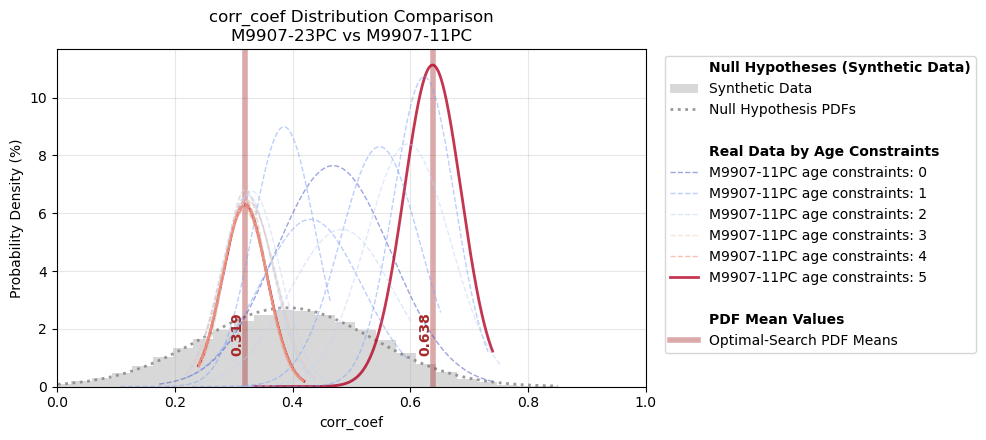


=== DETAILED STATISTICAL ANALYSIS FOR corr_coef ===
Null Hypothesis Distribution:
  Mean: 0.4, SD: 0.1
  Sample size: 451924
  Interpretation: Baseline distribution from synthetic data representing no true correlation

--- Optimal Search Results (Max Constraints Only) ---
Consider age strictly:
  Mean: 0.6, SD: 0.1
  t-statistic: 133.6 (measures difference between means relative to variation)
  z-statistic: 297.5 (standard deviations from null hypothesis mean)
  p-value: 0
  Cohen's d: 1.7
  Sample size: 6598
  Effect size: large difference between distributions
  Interpretation: Significantly higher than null hypothesis with large effect size

--- Random Search Results (Max Constraints Only) ---

✓ Combined plot saved as: outputs/r-values_comparison_M9907-23PC_M9907-11PC.png
✓ Analysis complete for corr_coef!

PROCESSING QUALITY INDEX: norm_dtw

--- Creating combined distribution plot for norm_dtw ---
✓ Loaded master CSV: outputs/norm_dtw_fit_params_M9907-23PC_M9907-11PC.csv
Loaded 3

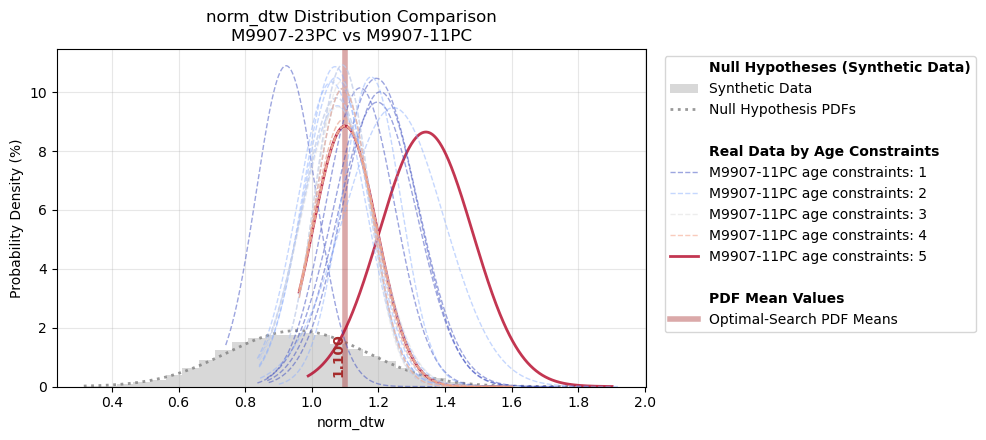


=== DETAILED STATISTICAL ANALYSIS FOR norm_dtw ===
Null Hypothesis Distribution:
  Mean: 1.0, SD: 0.2
  Sample size: 451924
  Interpretation: Baseline distribution from synthetic data representing no true correlation

--- Optimal Search Results (Max Constraints Only) ---
Consider age strictly:
  Mean: 1.1, SD: 0.1
  t-statistic: 7.8 (measures difference between means relative to variation)
  z-statistic: 17.2 (standard deviations from null hypothesis mean)
  p-value: 5.3e-15
  Cohen's d: 0.7
  Sample size: 130
  Effect size: medium difference between distributions
  Interpretation: Significantly higher than null hypothesis with medium effect size

Neglect age:
  Mean: 1.3, SD: 0.1
  t-statistic: 145.6 (measures difference between means relative to variation)
  z-statistic: 217.9 (standard deviations from null hypothesis mean)
  p-value: 0
  Cohen's d: 1.8
  Sample size: 6309
  Effect size: large difference between distributions
  Interpretation: Significantly higher than null hypothes

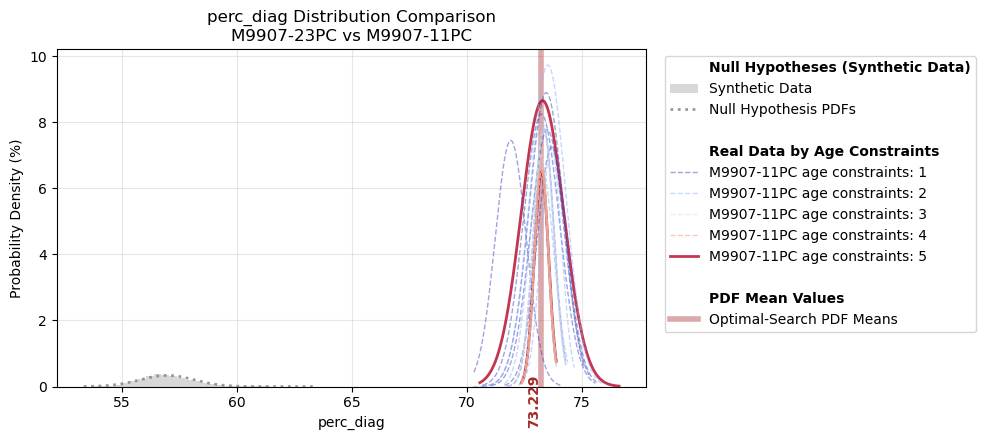


=== DETAILED STATISTICAL ANALYSIS FOR perc_diag ===
Null Hypothesis Distribution:
  Mean: 57.0, SD: 1.2
  Sample size: 451924
  Interpretation: Baseline distribution from synthetic data representing no true correlation

--- Optimal Search Results (Max Constraints Only) ---
Consider age strictly:
  Mean: 73.2, SD: 0.3
  t-statistic: 156.9 (measures difference between means relative to variation)
  z-statistic: 597.8 (standard deviations from null hypothesis mean)
  p-value: 0
  Cohen's d: 13.8
  Sample size: 130
  Effect size: large difference between distributions
  Interpretation: Significantly higher than null hypothesis with large effect size

Neglect age:
  Mean: 73.3, SD: 0.9
  t-statistic: 1091.2 (measures difference between means relative to variation)
  z-statistic: 1379.0 (standard deviations from null hypothesis mean)
  p-value: 0
  Cohen's d: 13.8
  Sample size: 6309
  Effect size: large difference between distributions
  Interpretation: Significantly higher than null hypot

In [ ]:
# Helper functions - moved outside the loop
def reconstruct_raw_data_from_histogram(bins, hist_percentages, n_points):
    """Reconstruct raw data points from histogram bins and percentages"""
    raw_data = []
    
    # Convert percentages to raw counts
    raw_counts = (hist_percentages * n_points) / 100
    
    # Generate data points for each bin
    for i, count in enumerate(raw_counts):
        if count > 0:
            n_samples = int(round(count))
            if n_samples > 0:
                # Sample uniformly within the bin
                bin_samples = np.random.uniform(bins[i], bins[i+1], n_samples)
                raw_data.extend(bin_samples)
    
    return np.array(raw_data)

def cohens_d(x, y):
    """Calculate Cohen's d for effect size between two samples"""
    n1, n2 = len(x), len(y)
    s1, s2 = np.std(x, ddof=1), np.std(y, ddof=1)
    # Pooled standard deviation
    s_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    # Cohen's d
    d = (np.mean(x) - np.mean(y)) / s_pooled
    return d

# Loop through all quality indices
quality_indices = ['corr_coef', 'norm_dtw', 'perc_diag']

for quality_index in quality_indices:
    print(f"\n{'='*80}")
    print(f"PROCESSING QUALITY INDEX: {quality_index}")
    print(f"{'='*80}")
    
    # Now create combined plot from master CSV
    print(f"\n--- Creating combined distribution plot for {quality_index} ---")

    # Load all fit_params from master CSV
    if quality_index == 'corr_coef':
        master_csv_filename = f'outputs/r-values_fit_params_{CORE_A}_{CORE_B}.csv'
    else:
        master_csv_filename = f'outputs/{quality_index}_fit_params_{CORE_A}_{CORE_B}.csv'
    
    # Check if master CSV exists
    if not os.path.exists(master_csv_filename):
        print(f"✗ Error: Master CSV file not found: {master_csv_filename}")
        print(f"   Skipping {quality_index} and moving to next index...")
        continue
    
    try:
        df_all_params = pd.read_csv(master_csv_filename)
        print(f"✓ Loaded master CSV: {master_csv_filename}")
    except Exception as e:
        print(f"✗ Error loading master CSV {master_csv_filename}: {str(e)}")
        print(f"   Skipping {quality_index} and moving to next index...")
        continue

    # Define which categories to load - you can customize these filters
    load_filters = {
        'age_consideration': [True, False],  # Load both True and False, or specify [True] for only True
        # 'restricted_age_correlation': [True, False, None],  # Load both True, False, and empty/NaN values
        'restricted_age_correlation': [True, None],  # Load both True, False, and empty/NaN values
        # 'shortest_path_search': [True, False]  # Load both, or specify [True] for only optimal search
        'shortest_path_search': [True]  # Load both, or specify [True] for only optimal search
    }

    # Apply filters with NaN handling
    mask = pd.Series([True] * len(df_all_params))
    for column, values in load_filters.items():
        if values is not None:  # Allow None to skip filtering on that parameter
            # Handle NaN/empty values in the filter
            if None in values:
                # Include rows where the column is NaN or in the specified values
                mask &= (df_all_params[column].isin([v for v in values if v is not None]) | 
                        df_all_params[column].isna())
            else:
                # Only include non-NaN values that match the filter
                mask &= df_all_params[column].isin(values)

    df_all_params = df_all_params[mask]
    print(f"Loaded {len(df_all_params)} rows after filtering")

    # Show what combinations were loaded (handle NaN display)
    print("Loaded parameter combinations:")
    loaded_combos = df_all_params.groupby(['age_consideration', 'restricted_age_correlation', 'shortest_path_search'], dropna=False).size().reset_index(name='count')
    for idx, row in loaded_combos.iterrows():
        restricted_val = row['restricted_age_correlation'] if pd.notna(row['restricted_age_correlation']) else 'None/Empty'
        print(f"  age_consideration={row['age_consideration']}, restricted_age_correlation={restricted_val}, shortest_path_search={row['shortest_path_search']} ({row['count']} rows)")

    #####

    # Load synthetic fit params from CSV for background
    # Define input filename based on log columns and quality index
    if LOG_COLUMNS == ['hiresMS']:
        synthetic_csv_filename = f'outputs/synthetic_PDFs_MSonly_{quality_index}.csv'
    elif LOG_COLUMNS == ['hiresMS','CT', 'Lumin']:
        synthetic_csv_filename = f'outputs/synthetic_PDFs_MSCTLumin_{quality_index}.csv'
    else:
        synthetic_csv_filename = f'outputs/synthetic_PDFs_unspecified_{quality_index}.csv'
    # Check if synthetic CSV exists
    if not os.path.exists(synthetic_csv_filename):
        print(f"✗ Error: Synthetic CSV file not found: {synthetic_csv_filename}")
        print(f"   Skipping {quality_index} and moving to next index...")
        continue
    
    try:
        df_synthetic_params = pd.read_csv(synthetic_csv_filename)
        print(f"✓ Loaded synthetic CSV: {synthetic_csv_filename}")
    except Exception as e:
        print(f"✗ Error loading synthetic CSV {synthetic_csv_filename}: {str(e)}")
        print(f"   Skipping {quality_index} and moving to next index...")
        continue

    # Reconstruct combined data from binned data (same as file_context_0)
    all_raw_data = []

    # Process each iteration to reconstruct raw data from binned data
    for _, row in df_synthetic_params.iterrows():
        # Extract binned data
        bins = np.fromstring(row['bins'].strip('[]'), sep=' ') if 'bins' in row and pd.notna(row['bins']) else None
        hist_percentages = np.fromstring(row['hist'].strip('[]'), sep=' ') if 'hist' in row and pd.notna(row['hist']) else None
        n_points = row['n_points'] if 'n_points' in row and pd.notna(row['n_points']) else None
        
        if bins is not None and hist_percentages is not None and n_points is not None:
            # Convert percentages back to raw counts
            raw_counts = (hist_percentages * n_points) / 100
            
            # Reconstruct data points by sampling from each bin
            bin_centers = (bins[:-1] + bins[1:]) / 2
            bin_width = bins[1] - bins[0]
            
            for i, count in enumerate(raw_counts):
                if count > 0:
                    # Generate random points within each bin
                    n_samples = int(round(count))
                    if n_samples > 0:
                        # Sample uniformly within the bin
                        bin_samples = np.random.uniform(
                            bins[i], bins[i+1], n_samples
                        )
                        all_raw_data.extend(bin_samples)

    # Convert to numpy array
    combined_data = np.array(all_raw_data)

    # Fit normal distribution to combined data
    from scipy import stats
    fitted_mean, fitted_std = stats.norm.fit(combined_data)

    # Generate fitted curve
    x_fitted = np.linspace(combined_data.min(), combined_data.max(), 1000)
    y_fitted = stats.norm.pdf(x_fitted, fitted_mean, fitted_std)

    # Create combined plot
    fig, ax = plt.subplots(figsize=(10, 4.5))

    # Plot combined histogram in gray bars (same style as file_context_0)
    n_bins = 30
    ax.hist(combined_data, bins=n_bins, alpha=0.3, color='gray', density=True, label='Synthetic Data')

    # Plot fitted normal curve as gray dotted line (same style as original synthetic curves)
    ax.plot(x_fitted, y_fitted, color='gray', linestyle=':', linewidth=2, alpha=0.8,
            label='Null Hypothesis PDFs')

    # Get unique combinations available in the CSV
    unique_combinations = df_all_params.drop_duplicates(
        subset=['age_consideration', 'restricted_age_correlation', 'shortest_path_search']
    )[['age_consideration', 'restricted_age_correlation', 'shortest_path_search']].to_dict('records')

    print(f"Found {len(unique_combinations)} unique parameter combinations in CSV:")
    for combo in unique_combinations:
        print(f"  {combo}")

    # Find max constraint counts for determining which curves to highlight
    max_core_a_constraints = df_all_params['core_a_constraints_count'].max()
    max_core_b_constraints = df_all_params['core_b_constraints_count'].max()
    
    print(f"Max core_a_constraints_count: {max_core_a_constraints}")
    print(f"Max core_b_constraints_count: {max_core_b_constraints}")

    # Set up colormap based on core_b_constraints_count
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    
    # Get range of core_b_constraints_count values
    min_core_b = df_all_params['core_b_constraints_count'].min()
    max_core_b = df_all_params['core_b_constraints_count'].max()
    
    # Create colormap
    cmap = cm.get_cmap('coolwarm')  # You can change this to other colormaps like 'viridis''plasma', 'inferno', etc.
    norm = colors.Normalize(vmin=min_core_b, vmax=max_core_b)

    # Separate combinations by search method and collect mean values for max constraint cases only
    optimal_combinations = []  # For shortest_path_search=True
    random_combinations = []   # For shortest_path_search=False

    solid_mean_values = []  # For optimal search group (max constraints only)
    dash_mean_values = []   # For random search group (max constraints only)

    for combo in unique_combinations:
        combo_data = df_all_params[
            (df_all_params['age_consideration'] == combo['age_consideration']) &
            (df_all_params['restricted_age_correlation'] == combo['restricted_age_correlation']) &
            (df_all_params['shortest_path_search'] == combo['shortest_path_search'])
        ]
        
        combo_mean_values = []
        for idx, row in combo_data.iterrows():
            if 'mean' in row and pd.notna(row['mean']):
                # Only collect means for max constraint cases
                if (row['core_a_constraints_count'] == max_core_a_constraints and 
                    row['core_b_constraints_count'] == max_core_b_constraints):
                    combo_mean_values.append(row['mean'])
        
        # Determine which search method group this combination belongs to
        if combo['shortest_path_search']:
            optimal_combinations.append(combo)
            solid_mean_values.extend(combo_mean_values)
        else:
            random_combinations.append(combo)
            dash_mean_values.extend(combo_mean_values)

    # Plot vertical lines for each search method group with text labels (max constraints only)
    solid_mean_plotted = False
    dash_mean_plotted = False

    if solid_mean_values:
        for mean_val in solid_mean_values:
            label = 'Optimal-Search PDF Means' if not solid_mean_plotted else ""
            ax.axvline(x=mean_val, color='brown', alpha=0.4, linewidth=4, label=label)
            # Add text label for mean value
            ax.text(mean_val, ax.get_ylim()[1] * 0.9, f'{mean_val:.3f}', 
                    rotation=90, ha='right', va='top', color='brown', fontweight='bold')
            solid_mean_plotted = True

    if dash_mean_values:
        for mean_val in dash_mean_values:
            label = 'Random-Search PDF Means' if not dash_mean_plotted else ""
            ax.axvline(x=mean_val, color='green', alpha=0.4, linewidth=4, label=label)
            # Add text label for mean value
            ax.text(mean_val, ax.get_ylim()[1] * 0.9, f'{mean_val:.3f}', 
                    rotation=90, ha='right', va='top', color='green', fontweight='bold')
            dash_mean_plotted = True

    # Collect real data for statistical tests - separate by individual distributions
    solid_real_data_by_combo = {}  # Dictionary to store data by combination
    dash_real_data_by_combo = {}

    # Plot each distribution curve and collect data for statistical tests
    solid_count = 0
    dash_count = 0

    # Track which constraint levels have been plotted for legend
    plotted_constraint_levels = set()

    for idx, row in df_all_params.iterrows():
        # Extract parameter values directly from CSV columns
        age_consideration = row['age_consideration']
        restricted_age_correlation = row['restricted_age_correlation']
        shortest_path_search = row['shortest_path_search']
        core_a_constraints = row['core_a_constraints_count']
        core_b_constraints = row['core_b_constraints_count']
        
        # Parse x_range and y_values from stored strings
        if 'x_range' in row and 'y_values' in row and pd.notna(row['x_range']) and pd.notna(row['y_values']):
            try:
                x_range = np.fromstring(row['x_range'].strip('[]'), sep=' ')
                y_values = np.fromstring(row['y_values'].strip('[]'), sep=' ')
                
                # Create unique key for this parameter combination
                combo_key = f"age_{age_consideration}_restricted_{restricted_age_correlation}_shortest_{shortest_path_search}"
                
                # Reconstruct raw data from histogram for statistical tests
                if 'bins' in row and 'hist' in row and 'n_points' in row and \
                   pd.notna(row['bins']) and pd.notna(row['hist']) and pd.notna(row['n_points']):
                    
                    bins = np.fromstring(row['bins'].strip('[]'), sep=' ')
                    hist_percentages = np.fromstring(row['hist'].strip('[]'), sep=' ')
                    n_points = row['n_points']
                    
                    # Reconstruct raw data points
                    raw_data_points = reconstruct_raw_data_from_histogram(bins, hist_percentages, n_points)
                    
                    # Group by search method based on shortest_path_search column
                    if shortest_path_search:
                        if combo_key not in solid_real_data_by_combo:
                            solid_real_data_by_combo[combo_key] = []
                        solid_real_data_by_combo[combo_key].extend(raw_data_points)
                    else:
                        if combo_key not in dash_real_data_by_combo:
                            dash_real_data_by_combo[combo_key] = []
                        dash_real_data_by_combo[combo_key].extend(raw_data_points)
                
                if len(x_range) > 0 and len(y_values) > 0:
                    # Create descriptive label based on parameter combination
                    # Determine age treatment description
                    if age_consideration:
                        if restricted_age_correlation:
                            age_desc = "Consider age strictly"
                        else:
                            age_desc = "Consider age loosely"
                    else:
                        age_desc = "Neglect age"
                    
                    # Determine if this is a max constraint case
                    is_max_constraints = (core_a_constraints == max_core_a_constraints and 
                                        core_b_constraints == max_core_b_constraints)
                    
                    # Get color from colormap based on core_b_constraints_count
                    color = cmap(norm(core_b_constraints))
                    
                    # Determine line style and transparency based on constraint levels
                    if is_max_constraints:
                        line_style = '-'  # Solid line
                        linewidth = 2
                        alpha = 0.8
                        # Create label for constraint level (for legend)
                        constraint_label = f'{CORE_B} age constraints: {core_b_constraints}'
                        if core_b_constraints not in plotted_constraint_levels:
                            label = constraint_label
                            plotted_constraint_levels.add(core_b_constraints)
                        else:
                            label = None  # Don't repeat in legend
                    else:
                        line_style = '--'  # Dashed line
                        linewidth = 1  # Thinner dashed lines
                        alpha = 0.5
                        # Create label for constraint level (for legend)
                        constraint_label = f'{CORE_B} age constraints: {core_b_constraints}'
                        if core_b_constraints not in plotted_constraint_levels:
                            label = constraint_label
                            plotted_constraint_levels.add(core_b_constraints)
                        else:
                            label = None  # Don't repeat in legend
                    
                    # Plot distribution curve
                    ax.plot(x_range, y_values, 
                           color=color, 
                           linestyle=line_style,
                           linewidth=linewidth, alpha=alpha, 
                           label=label)
            
            except Exception as e:
                print(f"Warning: Could not plot curve for row {idx}: {str(e)}")

    # Perform statistical tests for each individual distribution (only for max constraints)
    solid_stats_by_combo = {}
    dash_stats_by_combo = {}

    # Filter data to only include max constraint cases for statistical analysis
    max_constraint_data = df_all_params[
        (df_all_params['core_a_constraints_count'] == max_core_a_constraints) &
        (df_all_params['core_b_constraints_count'] == max_core_b_constraints)
    ]

    # Recalculate real data collections for max constraints only
    solid_real_data_by_combo_max = {}
    dash_real_data_by_combo_max = {}

    for idx, row in max_constraint_data.iterrows():
        age_consideration = row['age_consideration']
        restricted_age_correlation = row['restricted_age_correlation']
        shortest_path_search = row['shortest_path_search']
        
        combo_key = f"age_{age_consideration}_restricted_{restricted_age_correlation}_shortest_{shortest_path_search}"
        
        if 'bins' in row and 'hist' in row and 'n_points' in row and \
           pd.notna(row['bins']) and pd.notna(row['hist']) and pd.notna(row['n_points']):
            
            bins = np.fromstring(row['bins'].strip('[]'), sep=' ')
            hist_percentages = np.fromstring(row['hist'].strip('[]'), sep=' ')
            n_points = row['n_points']
            
            raw_data_points = reconstruct_raw_data_from_histogram(bins, hist_percentages, n_points)
            
            if shortest_path_search:
                if combo_key not in solid_real_data_by_combo_max:
                    solid_real_data_by_combo_max[combo_key] = []
                solid_real_data_by_combo_max[combo_key].extend(raw_data_points)
            else:
                if combo_key not in dash_real_data_by_combo_max:
                    dash_real_data_by_combo_max[combo_key] = []
                dash_real_data_by_combo_max[combo_key].extend(raw_data_points)

    # Calculate statistics for solid (optimal search) combinations - max constraints only
    for combo_key, data in solid_real_data_by_combo_max.items():
        if len(data) > 1:  # Need at least 2 data points for statistical tests
            data_array = np.array(data)
            t_stat, p_value = stats.ttest_ind(data_array, combined_data)
            
            # Replace z_test with one-sample t-test but keep variable name as z_stat
            null_mean = np.mean(combined_data)
            z_stat, _ = stats.ttest_1samp(data_array, null_mean)
            
            cohens_d_val = cohens_d(data_array, combined_data)
            
            solid_stats_by_combo[combo_key] = {
                't_stat': t_stat,
                'p_value': p_value,
                'z_stat': z_stat,  # This is actually a one-sample t-stat now
                'cohens_d': cohens_d_val,
                'n_samples': len(data_array),
                'mean': np.mean(data_array),
                'std': np.std(data_array)
            }

    # Calculate statistics for dash (random search) combinations - max constraints only
    for combo_key, data in dash_real_data_by_combo_max.items():
        if len(data) > 1:  # Need at least 2 data points for statistical tests
            data_array = np.array(data)
            t_stat, p_value = stats.ttest_ind(data_array, combined_data)
            
            # Replace z_test with one-sample t-test but keep variable name as z_stat
            null_mean = np.mean(combined_data)
            z_stat, _ = stats.ttest_1samp(data_array, null_mean)
            
            cohens_d_val = cohens_d(data_array, combined_data)
            
            dash_stats_by_combo[combo_key] = {
                't_stat': t_stat,
                'p_value': p_value,
                'z_stat': z_stat,  # This is actually a one-sample t-stat now
                'cohens_d': cohens_d_val,
                'n_samples': len(data_array),
                'mean': np.mean(data_array),
                'std': np.std(data_array)
            }

    # Formatting
    ax.set_xlabel(f"{quality_index}")
    ax.set_ylabel('Probability Density (%)')
    ax.set_title(f'{quality_index} Distribution Comparison\n{CORE_A} vs {CORE_B}')

    # Create grouped legend
    handles, labels = ax.get_legend_handles_labels()

    # Separate handles and labels by groups
    synthetic_handles = []
    synthetic_labels = []
    constraint_handles = []
    constraint_labels = []
    mean_handles = []
    mean_labels = []

    for handle, label in zip(handles, labels):
        if 'Null' in label or 'Synthetic' in label:
            synthetic_handles.append(handle)
            synthetic_labels.append(label)
        elif 'age constraints' in label:
            constraint_handles.append(handle)
            constraint_labels.append(label)
        elif 'PDF Means' in label:
            mean_handles.append(handle)
            mean_labels.append(label)

    # Create grouped legend with titles and detailed statistics
    from matplotlib.lines import Line2D

    legend_elements = []
    legend_labels = []

    # Add synthetic group
    if synthetic_handles:
        # Add group title (invisible line)
        legend_elements.append(Line2D([0], [0], color='white', linewidth=0, alpha=0))
        legend_labels.append('Null Hypotheses (Synthetic Data)')
        # Add actual legend items
        legend_elements.extend(synthetic_handles)
        legend_labels.extend(synthetic_labels)
        # Add spacer
        legend_elements.append(Line2D([0], [0], color='white', linewidth=0, alpha=0))
        legend_labels.append('')

    # Add constraint level group
    if constraint_handles:
        # Add group title (invisible line)
        legend_elements.append(Line2D([0], [0], color='white', linewidth=0, alpha=0))
        legend_labels.append('Real Data by Age Constraints')
        
        # Sort constraint handles and labels by constraint count
        constraint_pairs = list(zip(constraint_handles, constraint_labels))
        constraint_pairs.sort(key=lambda x: int(x[1].split(': ')[-1]))
        
        for handle, label in constraint_pairs:
            legend_elements.append(handle)
            legend_labels.append(label)
        
        # Add spacer
        legend_elements.append(Line2D([0], [0], color='white', linewidth=0, alpha=0))
        legend_labels.append('')

    # Add mean lines group
    if mean_handles:
        # Add group title (invisible line)
        legend_elements.append(Line2D([0], [0], color='white', linewidth=0, alpha=0))
        legend_labels.append('PDF Mean Values')
        # Add actual legend items
        legend_elements.extend(mean_handles)
        legend_labels.extend(mean_labels)

    # Apply legend with grouping
    legend = ax.legend(legend_elements, legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left')

    # Style the group title labels
    for i, label in enumerate(legend_labels):
        if (label.startswith('Null Hypotheses') or 
            label.startswith('Real Data by Age Constraints') or 
            label.startswith('PDF Mean Values')):
            legend.get_texts()[i].set_weight('bold')
            legend.get_texts()[i].set_fontsize(10)
            legend.get_texts()[i].set_ha('left')  # Align to left

    ax.grid(True, alpha=0.3)
    if quality_index == 'corr_coef':
        ax.set_xlim(0, 1.0)
    # For other indices, let matplotlib auto-scale

    plt.tight_layout()
    if quality_index == 'corr_coef':
        plt.savefig(f'outputs/r-values_comparison_{CORE_A}_{CORE_B}.png', dpi=150, bbox_inches='tight')
    else:
        plt.savefig(f'outputs/{quality_index}_comparison_{CORE_A}_{CORE_B}.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print detailed statistical results
    print(f"\n=== DETAILED STATISTICAL ANALYSIS FOR {quality_index} ===")
    print(f"Null Hypothesis Distribution:")
    print(f"  Mean: {fitted_mean:.1f}, SD: {fitted_std:.1f}")
    print(f"  Sample size: {len(combined_data)}")
    print(f"  Interpretation: Baseline distribution from synthetic data representing no true correlation")
    print()

    print(f"--- Optimal Search Results (Max Constraints Only) ---")
    for combo_key, stats in solid_stats_by_combo.items():
        # Parse combo_key to get descriptive name
        if "age_True_restricted_True" in combo_key:
            desc = "Consider age strictly"
        elif "age_True_restricted_False" in combo_key:
            desc = "Consider age loosely"
        elif "age_False" in combo_key:
            desc = "Neglect age"
        else:
            desc = combo_key
        
        print(f"{desc}:")
        print(f"  Mean: {stats['mean']:.1f}, SD: {stats['std']:.1f}")
        print(f"  t-statistic: {stats['t_stat']:.1f} (measures difference between means relative to variation)")
        print(f"  z-statistic: {stats['z_stat']:.1f} (standard deviations from null hypothesis mean)")
        print(f"  p-value: {stats['p_value']:.2g}")
        print(f"  Cohen's d: {stats['cohens_d']:.1f}")
        print(f"  Sample size: {stats['n_samples']}")
        
        # Interpret effect size
        if abs(stats['cohens_d']) < 0.2:
            effect_size = "negligible"
        elif abs(stats['cohens_d']) < 0.5:
            effect_size = "small"
        elif abs(stats['cohens_d']) < 0.8:
            effect_size = "medium"
        else:
            effect_size = "large"
        
        # Statistical interpretation
        if stats['t_stat'] > 0:
            direction = "higher than"
        else:
            direction = "lower than"
        
        print(f"  Effect size: {effect_size} difference between distributions")
        
        # Only use "significantly" if p-value indicates statistical significance
        if stats['p_value'] < 0.05:
            print(f"  Interpretation: Significantly {direction} null hypothesis with {effect_size} effect size")
        else:
            print(f"  Interpretation: no statistical significance (p-value = {stats['p_value']:.2e})")
        print()
        

    print(f"--- Random Search Results (Max Constraints Only) ---")
    for combo_key, stats in dash_stats_by_combo.items():
        # Parse combo_key to get descriptive name
        if "age_True_restricted_True" in combo_key:
            desc = "Consider age strictly"
        elif "age_True_restricted_False" in combo_key:
            desc = "Consider age loosely"
        elif "age_False" in combo_key:
            desc = "Neglect age"
        else:
            desc = combo_key
        
        print(f"{desc}:")
        print(f"  Mean: {stats['mean']:.1f}, SD: {stats['std']:.1f}")
        print(f"  t-statistic: {stats['t_stat']:.1f} (measures difference between means relative to variation)")
        print(f"  z-statistic: {stats['z_stat']:.1f} (standard deviations from null hypothesis mean)")
        print(f"  p-value: {stats['p_value']:.2g}")
        print(f"  Cohen's d: {stats['cohens_d']:.1f}")
        print(f"  Sample size: {stats['n_samples']}")
        
        # Interpret effect size
        if abs(stats['cohens_d']) < 0.2:
            effect_size = "negligible"
        elif abs(stats['cohens_d']) < 0.5:
            effect_size = "small"
        elif abs(stats['cohens_d']) < 0.8:
            effect_size = "medium"
        else:
            effect_size = "large"
        
        # Statistical interpretation
        if stats['t_stat'] > 0:
            direction = "higher than"
        else:
            direction = "lower than"
        
        print(f"  Effect size: {effect_size} difference between distributions")
        
        # Only use "significantly" if p-value indicates statistical significance
        if stats['p_value'] < 0.05:
            print(f"  Interpretation: Significantly {direction} null hypothesis with {effect_size} effect size")
        else:
            print(f"  Interpretation: no statistical significance (p-value = {stats['p_value']:.2e})")
        print()

    if quality_index == 'corr_coef':
        print(f"\n✓ Combined plot saved as: outputs/r-values_comparison_{CORE_A}_{CORE_B}.png")
    else:
        print(f"\n✓ Combined plot saved as: outputs/{quality_index}_comparison_{CORE_A}_{CORE_B}.png")
    print(f"✓ Analysis complete for {quality_index}!")

print(f"\n{'='*80}")
print(f"ALL QUALITY INDICES PROCESSING COMPLETED")
print(f"{'='*80}")